<a href="https://colab.research.google.com/github/Ravi7090/AI_DATA_ANALYSIS_/blob/main/RKR123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating a dummy 'financial_transactions.csv' for demonstration...


<ipython-input-1-406dbcf91760>:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'Timestamp': pd.to_datetime(pd.date_range('2023-01-01', periods=n_normal, freq='T')),
<ipython-input-1-406dbcf91760>:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'Timestamp': pd.to_datetime(pd.date_range('2023-01-10', periods=n_anomalies, freq='H')), # Different time pattern


Dummy 'financial_transactions.csv' created with 10000 normal and 100 anomaly transactions.

Successfully loaded data from 'financial_transactions.csv'

Data Head:
   Transaction_ID  Transaction_Amount            Timestamp Location  \
0            7401          557.404193  2023-01-06 03:21:00    CityC   
1            5834          518.430906  2023-01-05 01:14:00    CityB   
2            2122          498.073962  2023-01-02 11:22:00    CityE   
3            8788          567.929382  2023-01-07 02:28:00    CityE   
4             304          497.909841  2023-01-01 05:04:00    CityA   

  Merchant_Type  Location_Risk_Score  
0   Restaurants             4.822649  
1        Travel             1.737328  
2        Travel             3.882508  
3   Electronics             3.672803  
4   Electronics             1.515115  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  -

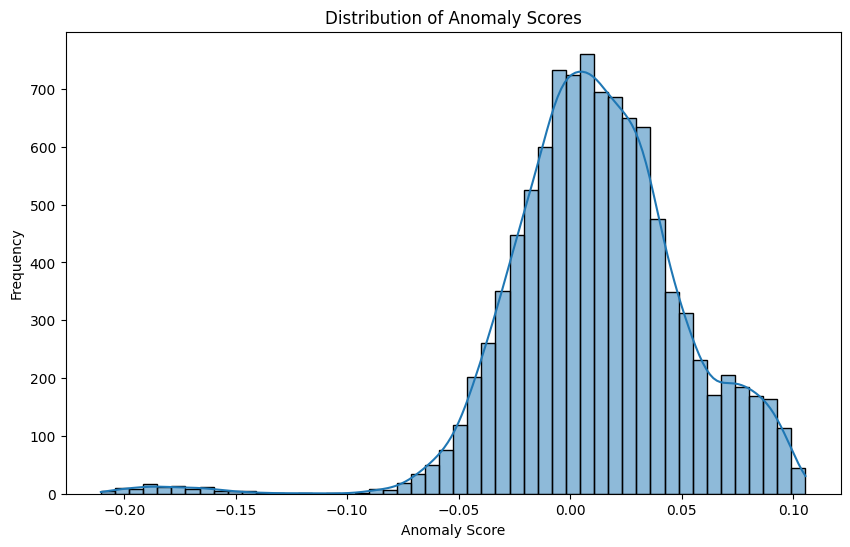

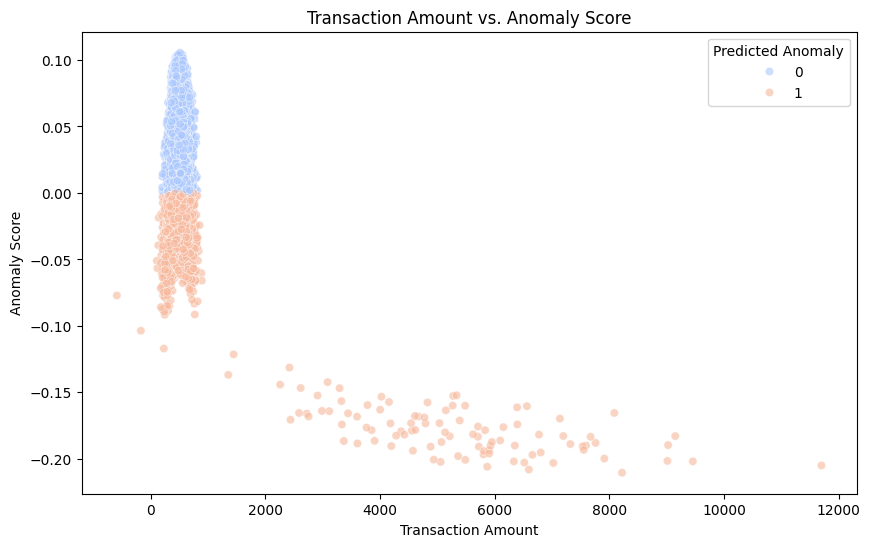


--- Interpretation ---
Transactions with 'is_anomaly_predicted' = 1 are flagged as potential anomalies.
The 'anomaly_score' indicates the degree of anomalousness (lower score is more anomalous).
Based on the Isolation Forest with contamination='auto', 3768 transactions were flagged.

Review the flagged transactions (especially those with the lowest anomaly scores) for potential fraudulent or unusual activity.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os # Import os for checking file existence

# --- Configuration ---
CSV_FILE_PATH = 'financial_transactions.csv' # <--- **Replace with the path to your CSV file**
# Define the features to use for anomaly detection
# <--- **Update these lists based on the columns in your CSV file**
FEATURES = ['Transaction_Amount', 'Time_of_Day_Hour', 'Day_of_Week', 'Location_Risk_Score']
CATEGORICAL_FEATURES = ['Merchant_Type'] # List of categorical columns to one-hot encode

# --- Create a dummy CSV file for demonstration if it doesn't exist ---
# You can skip this part if you have your own CSV
if not os.path.exists(CSV_FILE_PATH):
    print(f"Creating a dummy '{CSV_FILE_PATH}' for demonstration...")
    np.random.seed(42)

    # Generate normal transactions
    n_normal = 10000
    normal_data = {
        'Transaction_ID': range(n_normal),
        'Transaction_Amount': np.random.normal(500, 100, n_normal),
        'Timestamp': pd.to_datetime(pd.date_range('2023-01-01', periods=n_normal, freq='T')),
        'Location': np.random.choice(['CityA', 'CityB', 'CityC', 'CityD', 'CityE'], n_normal),
        'Merchant_Type': np.random.choice(['Groceries', 'Electronics', 'Travel', 'Restaurants', 'Services'], n_normal),
        'Location_Risk_Score': np.random.uniform(1, 5, n_normal)
    }
    normal_df = pd.DataFrame(normal_data)

    # Introduce some anomalies (e.g., unusually high amounts, different patterns)
    n_anomalies = 100
    anomaly_data = {
        'Transaction_ID': range(n_normal, n_normal + n_anomalies),
        'Transaction_Amount': np.random.normal(5000, 2000, n_anomalies), # Higher amounts
        'Timestamp': pd.to_datetime(pd.date_range('2023-01-10', periods=n_anomalies, freq='H')), # Different time pattern
        'Location': np.random.choice(['CityZ', 'CityY', 'CityX'], n_anomalies), # Unusual locations
        'Merchant_Type': np.random.choice(['Jewelry', 'Luxury Goods', 'International Transfer'], n_anomalies), # Unusual merchants
        'Location_Risk_Score': np.random.uniform(8, 10, n_anomalies) # Higher risk
    }
    anomaly_df = pd.DataFrame(anomaly_data)

    # Combine and save to CSV
    dummy_df = pd.concat([normal_df, anomaly_df], ignore_index=True)
    dummy_df = dummy_df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle
    dummy_df.to_csv(CSV_FILE_PATH, index=False)
    print(f"Dummy '{CSV_FILE_PATH}' created with {n_normal} normal and {n_anomalies} anomaly transactions.")

# --- Load Data from CSV ---
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"\nSuccessfully loaded data from '{CSV_FILE_PATH}'")
    print("\nData Head:")
    print(df.head())
    print("\nData Info:")
    df.info()
except FileNotFoundError:
    print(f"\nError: The file '{CSV_FILE_PATH}' was not found.")
    print("Please make sure the CSV file is in the correct directory or update the CSV_FILE_PATH.")
    exit() # Exit if the file is not found

# --- Preprocessing ---

# Convert Timestamp to datetime objects and extract time-based features
# Ensure the 'Timestamp' column exists in your CSV and is correctly named
if 'Timestamp' in df.columns:
    try:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Time_of_Day_Hour'] = df['Timestamp'].dt.hour
        df['Day_of_Week'] = df['Timestamp'].dt.dayofweek # Monday=0, Sunday=6
        # Add 'Time_of_Day_Hour' and 'Day_of_Week' to the FEATURES list if you want to use them
        # Check if they are not already in the list before adding
        if 'Time_of_Day_Hour' not in FEATURES: FEATURES.append('Time_of_Day_Hour')
        if 'Day_of_Week' not in FEATURES: FEATURES.append('Day_of_Week')
        print("\nExtracted time-based features from 'Timestamp'.")
    except Exception as e:
        print(f"Warning: Could not process 'Timestamp' column. Error: {e}")
        print("Ensure the 'Timestamp' column is in a valid datetime format.")
        # Remove time-based features from FEATURES if they were added assuming Timestamp existed
        FEATURES = [f for f in FEATURES if f not in ['Time_of_Day_Hour', 'Day_of_Week']]
else:
    print("\nWarning: 'Timestamp' column not found. Time-based features will not be created or used.")
    # Remove time-based features from FEATURES if they were added assuming Timestamp existed
    FEATURES = [f for f in FEATURES if f not in ['Time_of_Day_Hour', 'Day_of_Week']]


# Handle categorical features using one-hot encoding
# Ensure only columns present in the DataFrame and listed in CATEGORICAL_FEATURES are processed
categorical_cols_present = [col for col in CATEGORICAL_FEATURES if col in df.columns]
if categorical_cols_present:
    print(f"\nEncoding categorical features: {categorical_cols_present}")
    df = pd.get_dummies(df, columns=categorical_cols_present, drop_first=True)
    # Update FEATURES list to include the new one-hot encoded columns
    # Avoid adding duplicates
    encoded_cols = [col for col in df.columns if any(cat + '_' in col for cat in categorical_cols_present) and col not in FEATURES]
    FEATURES.extend(encoded_cols)
else:
     print("\nNo specified categorical features found in the dataset for encoding.")


# Select only the defined features for the model
# Ensure all FEATURES actually exist in the DataFrame after preprocessing
model_features = [f for f in FEATURES if f in df.columns]
if not model_features:
    print("\nError: No valid features found for the model after preprocessing. Please check your FEATURES list and CSV columns.")
    print("Available columns after preprocessing:", df.columns.tolist())
    exit()

print(f"\nFeatures used for the model ({len(model_features)}): {model_features}")
X = df[model_features]

# Handle potential missing values (replace NaN with a suitable value)
# Isolation Forest can handle NaNs, but it's generally better to impute them.
# Here we fill with the mean, but consider other strategies like median or a constant value.
print(f"\nMissing values before handling:\n{X.isnull().sum()}")
if X.isnull().sum().sum() > 0:
    # Fill only the columns with missing values to avoid SettingWithCopyWarning
    for col in X.columns:
        if X[col].isnull().any():
            mean_val = X[col].mean()
            X[col].fillna(mean_val, inplace=True)
    print(f"Missing values after handling:\n{X.isnull().sum()}")
else:
    print("No missing values found.")


# --- Anomaly Detection using Isolation Forest ---
# Initialize the Isolation Forest model
# contamination: the proportion of outliers in the data.
# Set this based on your estimate of the percentage of anomalous transactions.
# Using 'auto' lets the algorithm decide, but a specific float (e.g., 0.01 for 1%) is common.
model = IsolationForest(n_estimators=100, # Number of trees in the forest
                        contamination='auto', # Estimate the proportion of anomalies
                        random_state=42,
                        n_jobs=-1) # Use all available CPU cores

print("\nTraining Isolation Forest model...")
# Train the model on the features
model.fit(X)
print("Training complete.")

# Predict anomalies on the same data used for training
# predict returns 1 for normal, -1 for anomaly
df['is_anomaly_predicted'] = model.predict(X)

# Get the anomaly scores (lower score indicates higher anomaly likelihood)
# The decision_function provides the anomaly score for each sample.
df['anomaly_score'] = model.decision_function(X)

# Convert predictions to binary (0 for normal, 1 for anomaly)
df['is_anomaly_predicted'] = df['is_anomaly_predicted'].apply(lambda x: 1 if x == -1 else 0)

# --- Analyze and Visualize Results ---

print("\n--- Anomaly Detection Results ---")

predicted_anomalies = df[df['is_anomaly_predicted'] == 1]
print(f"\nTotal transactions predicted as anomalies: {predicted_anomalies.shape[0]}")

print("\nSample transactions predicted as anomalies (first 5):")
print(predicted_anomalies.head())

# Optional: Display the most anomalous transactions based on score
print("\nTop 10 most anomalous transactions by score (lower score = more anomalous):")
print(df.sort_values(by='anomaly_score').head(10))


# Visualize anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of a key feature vs. anomaly score
# Replace 'Transaction_Amount' with one of your primary features if needed
if 'Transaction_Amount' in df.columns and 'anomaly_score' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['Transaction_Amount'], y=df['anomaly_score'], hue=df['is_anomaly_predicted'], palette='coolwarm', alpha=0.6)
    plt.title('Transaction Amount vs. Anomaly Score')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Anomaly Score')
    plt.legend(title='Predicted Anomaly')
    plt.show()
elif 'Transaction_Amount' not in df.columns:
     print("\n'Transaction_Amount' column not found for scatter plot visualization.")


# You can add more visualizations based on other features vs. anomaly score

# --- Interpretation ---
print("\n--- Interpretation ---")
print("Transactions with 'is_anomaly_predicted' = 1 are flagged as potential anomalies.")
print("The 'anomaly_score' indicates the degree of anomalousness (lower score is more anomalous).")
print(f"Based on the Isolation Forest with contamination='{model.contamination}', {predicted_anomalies.shape[0]} transactions were flagged.")
print("\nReview the flagged transactions (especially those with the lowest anomaly scores) for potential fraudulent or unusual activity.")

# Note: In a real-world scenario without true anomaly labels, evaluating performance
# is challenging. You would typically involve domain experts to review the flagged
# anomalies and provide feedback to refine the model or detection thresholds.